In [1]:
import xarray as xr
#import netCDF4
import json
import pandas as pd
import numpy as np
import pytz
import pyproj

from datetime import datetime, timedelta

from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *

from dispel4py.base import create_iterative_chain, ConsumerPE, IterativePE, SimpleFunctionPE

In [2]:
class ReadCSV(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('csvOutput')
    
    def _process(self,inputs):
        self.log('Reading CSV')
        csvFile = inputs['input'][0]
        csvMeta = inputs['csv_desc'][0]
        
        headerText = self.readHeaderLines(csvFile)
        
        self.invalidDateTime = np.datetime64('4000-01-01')
        
        #TODO: if needed port the json handling method
        self.metaCSVdict = self.readJson(csvMeta)
        delimiter = self.metaCSVdict['csvSeparator']
        columnsList = []
        columnsList.append(self.metaCSVdict['columnDate'])
        columnsList.append(self.metaCSVdict['columnHour'])
        columnsList.append(self.metaCSVdict['columnMinute'])
        columnsList.append(self.metaCSVdict['columnX'])
        columnsList.append(self.metaCSVdict['columnY'])        
        
        
        self.dataUnsortedStr = np.recfromtxt(csvFile, skip_header=self.numHeaderLines, comments="#", dtype="|S300",  delimiter=delimiter)
        self.dataColumns = self.dataUnsortedStr[:, columnsList ]
        self.log(self.dataColumns)
        
        rowCounter = 0
        queryDataArray = []        
        for oneRow in self.dataColumns:
            (utcTimeStr, utcTime) = self.decodeDateTime(dateStr=oneRow[0], hourStr=oneRow[1], minuteStr=oneRow[2])
            if utcTimeStr==None:  # None means INVALID request!
                dataRow = [ rowCounter, self.invalidDateTime, "INVALID", float(oneRow[3]), float(oneRow[4]) ]  
                # store [id, utc-time, utc-time-str, X-coord, Y-coord ]
                queryDataArray.append( dataRow )
            else:
                dataRow = [ rowCounter, np.datetime64(utcTime), utcTimeStr, float(oneRow[3]), float(oneRow[4]) ]  
                # store [id, utc-time, utc-time-str, X-coord, Y-coord ]
                queryDataArray.append( dataRow )
            rowCounter += 1
            
        ## Translate the python list to a 2 dimensional numpy array of [ [id, utc-time, X-coord, Y-coord], ... ]
        queryDataNPA = np.array(queryDataArray)

        self.timeUnits = "" #self.metaData.variables['time'].units
        self.dateTimeArray = queryDataNPA[:,1]
        
        # remove invalid dateTime records from the array
        indexDelete = np.where(self.dateTimeArray == self.invalidDateTime) # reserved  for "INVALID"
        self.dateTimeArrayClean = np.delete(self.dateTimeArray, indexDelete)
        
        # np.datetime64 => datetime; The date-time must be in UTC
        self.minDateTime = np.min(self.dateTimeArrayClean).astype(datetime.datetime).replace(tzinfo=pytz.UTC)
        self.maxDateTime = np.max(self.dateTimeArrayClean).astype(datetime.datetime).replace(tzinfo=pytz.UTC)

        fmt = '%Y-%m-%d %H:%M:%S %Z'
        self.minDateTime_str = self.minDateTime.strftime(fmt) 
        self.maxDateTime_str = self.maxDateTime.strftime(fmt)

        queryDataNPAdt = queryDataNPA ## create sorted 2-dimensional array
        self.queryDataNPAdt = queryDataNPAdt
        
        self.projFuncDefstring = self.metaCSVdict['projString']
        self.projectionFunction = pyproj.Proj(self.projFuncDefstring)
        
        # 2-dimensional numpy array [  [id, utc-time, X-coord, Y-coord ], .. ] sorted by utc time
        xcoords = queryDataNPAdt[:,3] ## still a 1-dimensional numpy array of strings
        ycoords = queryDataNPAdt[:,4] ## still a 1-dimensional numpy array of strings
        
        (longitudes,latitudes) = self.unproject2LongitudeLatitudes(xcoords, ycoords)
        lonLatStacked = np.vstack((longitudes,latitudes)).T
        #print lonLatStacked

        ## Determine the bounding box.
        self.llbox_west = np.min(longitudes)
        self.llbox_east = np.max(longitudes)
        self.llbox_north = np.max(latitudes)
        self.llbox_south = np.min(latitudes)
    
        self.queryDataNPAdtsLL = np.vstack(( queryDataNPAdt[:,0], queryDataNPAdt[:,1], longitudes,latitudes)).T
        
        #self.log(self.queryDataNPAdtsLL)
        
        self.write( 'csvOutput' , self.queryDataNPAdtsLL )
        
    
    def readHeaderLines(self, fileName):
        self.numHeaderLines = 1
        headerText = ""
        n = self.numHeaderLines
        ftxt = open(fileName,'rU')
        while n>0:
            ln = ftxt.readline()
            if not ln:
                break
            headerText += ln.rstrip('\n')  
            n -= 1
        ftxt.close()
        return headerText
    
    def readJson(self, fileName):
        with open(fileName) as json_file:  
            data = json.load(json_file)
        return data
    
    def decodeDateTime(self, dateStr, hourStr, minuteStr):

        if self.metaCSVdict['dateFormat'] == "%d%b%y":
            givenDate = datetime.datetime.strptime(dateStr, "%d%b%y")
            
        if self.metaCSVdict['hourFormat'] == "hourInterval":
            try:
                if '-' in hourStr:
                    hour = float(hourStr.split('-')[0])
                else:
                    hour = float(hourStr[:3])
            except:
                if self.autoResolve_hour>0:
                    hour = self.autoResolve_hour
                else:
                    try:
                        minute = int(minuteStr)
                        self.log('WARNING: could not extract (hour) from: "(%s)"' %(hourStr) )
                    except:
                        self.log('WARNING: could not extract (hour & minute) from: "(%s,%s)"' %(hourStr,minuteStr) )
                    
                    return None,None  # this mean INVALID request

            try:
                minute = int(minuteStr)
            except:
                if self.autoResolve_minute>0:
                    minute = self.autoResolve_minute
                else:
                    self.log('WARNING: could not extract minute from: "%s"' %(minuteStr) )
                    return None,None  # this mean INVALID request

            
        localTime = givenDate + timedelta(hours=hour, minutes=minute)
        
        (utcTime, datetime_in_utc_str, datetime_with_tz_str)  = self.convertLocalDateTime2Utc(localTime, zone=self.metaCSVdict['timeZone'])
        
        fmt = '%Y-%m-%d %H:%M:%S %Z'
        utcTimeStr = utcTime.strftime(fmt)
        return (utcTimeStr, utcTime)
        
    def convertLocalDateTime2Utc(self,datetime_without_tz, zone):
        fmt = '%Y-%m-%d %H:%M:%S %Z (%z)'
       
        local_tz = pytz.timezone (zone)

        needToDecide = False
        try:
            datetime_with_tz   = local_tz.localize(datetime_without_tz, is_dst=None) # No daylight saving time
        except pytz.exceptions.AmbiguousTimeError:
            needToDecide = True
        except pytz.exceptions.NonExistentTimeError:
            needToDecide = True
        if needToDecide:
            datetime_with_tz   = local_tz.localize(datetime_without_tz, is_dst=False) 
        
        datetime_in_utc    = datetime_with_tz.astimezone(pytz.utc)

        datetime_with_tz_str = datetime_with_tz.strftime(fmt)
        datetime_in_utc_str  = datetime_in_utc.strftime(fmt)

        return (datetime_in_utc, datetime_in_utc_str, datetime_with_tz_str)
    
    def unproject2LongitudeLatitudes(self, xcoords, ycoords):
        LL  = self.projectionFunction(xcoords, ycoords,inverse=True)
        longitudes = LL[0]
        latitudes = LL[1]
        return (longitudes,latitudes) # tuple, vector
        


In [3]:
class ReadNETCDF(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('netcdf_out')
    
    def _process(self,inputs):
        self.log('reading netcdf')
        netcdfFile = inputs['input'][0]
        fmt = '%Y-%m-%d %H:%M:%S %Z'
        
        #open  NetCDF dataset with xarray
        ds = xr.open_dataset(netcdfFile)
        
        #Time variables
        dt = ds['time'] #date-time DataArray
        timeDim = dt.shape[0]
         
        minDateTimeArray = np.min(dt) #returns minDate in a DataArray
        maxDateTimeArray = np.max(dt)
        minDateTime = minDateTimeArray.values #gets the value out of the DataArray
        maxDateTime = maxDateTimeArray.values
        
        minDateTime_conv = pd.to_datetime(minDateTime) #converts numpy datetime64 to datetime (better for readability)
        minDataTime_str = minDateTime_conv.strftime(fmt)
        maxDateTime_conv = pd.to_datetime(maxDateTime)
        maxDataTime_str = maxDateTime_conv.strftime(fmt)
        
        
        timeDelta = np.timedelta64(dt[1].values - dt[0].values, 'm') #time delta between consecutive measurements in minutes
        
        #Spatial variables
        dx = ds['x']
        dy = ds['y']
        xDim = dx.shape[0]
        yDim = dy.shape[0]
        gridSize = xDim * yDim
        
        xAxis = dx.data[:]
        yAxis = dy.data[:]
        
        self.xcoords, self.ycoords  = np.meshgrid(xAxis, yAxis)
        
        self.projFuncDefstring = ds['projection'].proj4_params
        self.projectionFunction = pyproj.Proj(self.projFuncDefstring)
        
        (self.longitudes,self.latitudes) = self.unproject2LongitudeLatitudes(self.xcoords, self.ycoords)
        self.lonLatStacked = np.hstack((self.longitudes.reshape(gridSize,1),self.latitudes.reshape(gridSize,1)))
        
        self.llbox_west = np.min(self.longitudes)
        self.llbox_east = np.max(self.longitudes)
        self.llbox_north = np.max(self.latitudes)
        self.llbox_south = np.min(self.latitudes)
        
        #ds.__setitem__('lonLatStacked', (['locations','coordinates'] ,self.lonLatStacked))
        #ds.__setitem__('longitude', self.longitudes)
        #ds.__setitem__('latitude', self.latitudes)
        #self.log(self.longitudes)
        
        #self.log('lonlat:')
        #self.log(ds.variables['lonLatStacked'])
        
        #self.log('#####################################')
        #self.log(ds)
        
        self.write( 'netcdf_out' , ds)
        

        
    def unproject2LongitudeLatitudes(self, xcoords, ycoords):
        LL  = self.projectionFunction(xcoords, ycoords,inverse=True)
        longitudes = LL[0]
        latitudes = LL[1]
        return (longitudes,latitudes) # tuple, vector

In [4]:
class ProcessData(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('csvData')
        self._add_input('netcdfData')
        self._add_output('output')
    
    def _process(self,inputs):
        self.log('Processing Data')
        self.log(inputs)
        
        #csvData = inputs['csvData'][0]
        #netcdfData = inputs['netcdfData'][0]
        #self.log(csvData)
        #self.log(netcdfData)
        #self.log("########################################")
        #self.log(netcdfData['lonLatStacked'])
        #self.log(inputs)
        #self.dateTimeArray = netcdfData['time']
        
        #function used for getting the distance between 2 points
        geoTransfWGS84 = pyproj.Geod(ellps='WGS84')
        self.geoTransf = geoTransfWGS84
        
        #dx = netcdfData['x']
        #self.xDim = dx.shape[0]
        
        arrayName = 'precipitation_amount'
        
        
#        for timeLonLat in csvData:
#            idn     = timeLonLat[0]
#            utcTime = timeLonLat[1]
#            lon     = timeLonLat[2]
#            lat     = timeLonLat[3]
#            value = self.GetValue_time_lon_lat(arrayName, utcTime, lon, lat)
#            valueList.append(value)
#        valueArray = np.array(valueList)
        
    def GetValue_time_lon_lat(self, arrayName, utcTime, lon, lat):
        closestDateTimeIndex = self.FindClosestDateTimeIndex(utcTime)
        
        minDistanceDataIndex = self.FindClosestLonLatPointIndex(lon, lat)
        
        dataValue = self.GetDataAtIndex(closestDateTimeIndex, minDistanceDataIndex, variableName=arrayName)
        
        return dataValue
    
    
    def FindClosestDataTimeIndex(self, time):
        closestTime = self.FindClosestDateTime(time, self.dateTimeArray)
        closestTimeIndex = np.where(self.dateTimeArray == closestTime)[0][0]
        return closestTimeIndex
    
    def FindClosestDateTime(self, givenDateTime, dateTimeList):
        pivot = np.datetime64(givenDateTime)
        return min(dateTimeList, key=lambda x: abs(x - pivot))
    
    def FindClosestLonLatPointIndex(self, lon, lat):
        self.givenLon = lon
        self.givenLat = lat
    
        idx = 0
        distArray = np.zeros(self.lonLatStacked.shape[0]).astype(np.float)
        for tupleLL in self.lonLatStacked:
            dist = self.Distance2pointsInLonLat(lon, lat, tupleLL[0], tupleLL[1])
            distArray[idx] = dist
            idx +=1
        minDist = np.min(distArray)
        minDistIndex = np.where(distArray == minDist)[0][0]
        return minDistIndex
    
    def Distance2pointsInLonLat(self, lng1,lat1,lng2,lat2):
        #global geoTransfWGS84
        #geoTransfWGS84
        az12,az21,dist = self.geoTransf.inv(lng1,lat1,lng2,lat2)
        return dist
        
    def GetDataAtIndex(self, timeIndex, dataIndex, variableName='precipitation_amount'):
        idX = dataIndex % self.xDim
        idY = dataIndex / self.xDim
        #variableFound = self.GetVariable(variableName)
        variableFound = self.netcdfData['image1_image_data']
        if variableFound:
            dataValue = variableFound[timeIndex][idY][idX]
            return dataValue
        else:
            return None
    
    
    #needs to be adapted to xarray
    def GetVariable(self, variableName):
        keylist = self.metaData.variables.keys()
        variableFound = None
        for k in keylist:
            try:
                if self.metaData.variables[k].standard_name == variableName:
                    #  self.metaData.variables['image1_image_data'].standard_name == variableName ..
                    variableFound = self.metaData.variables[k]
            except:
                pass
        return variableFound


In [5]:
class StoreData(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('location')
         
        
    def _process(self,inputs):
        self.log('Storing Data')
        outputLocation = "data/wrangled_data.csv"        

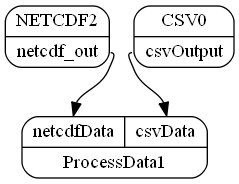

In [6]:
def createWorkflow():
    read_csv = ReadCSV()
    read_csv.name = 'CSV'
    read_netcdf = ReadNETCDF()
    read_netcdf.name = 'NETCDF'
    compute = ProcessData()
    store = StoreData()
    
    graph = WorkflowGraph()
    graph.connect(read_csv, 'csvOutput', compute, 'csvData')
    graph.connect(read_netcdf, 'netcdf_out', compute, 'netcdfData')
    #graph.connect(compute, 'output', store, 'location')
    
    return graph


workflow_graph = createWorkflow()

from dispel4py.visualisation import display
display(workflow_graph)

In [7]:
input_data = {     
                'CSV': [{ 'input': [ 'data/accident_data.csv'], 'csv_desc': ['data/metaDataCsv.json'] }],
                'NETCDF': [{ 'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/DATALAB/hackathon/radarFull2006.nc'] }]
                #'NETCDF': [ { 'input': [ 'data/radarFull2006.nc'] }] too large for GitHub
             }

In [8]:
def runWorkflow():
                                                     
    print input_data                   

    #Launch in simple process
    result = simple_process.process_and_return(workflow_graph, input_data)
    print "\n RESULT: "+str(result)


In [9]:
runWorkflow()

{'CSV': [{'csv_desc': ['data/metaDataCsv.json'], 'input': ['data/accident_data.csv']}], 'NETCDF': [{'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/DATALAB/hackathon/radarFull2006.nc']}]}
NETCDF2: reading netcdf
CSV0: Reading CSV
CSV0: [['03JAN06' '1.00-01.59' '10' '111998' '516711']
 ['07JAN06' '7.00-07.59' '50' '95069' '451430']
 ['21JAN06' '11.00-11.59' '10' '119330.273' '486468.495']
 ['13JAN06' '12.00-12.59' '45' '91939' '440711']
 ['09JAN06' '18.00-18.59' '9' '190371.475' '324748.091']
 ['03JAN06' '8.00-08.59' '15' '258048' '468749']
 ['12JAN06' '17.00-17.59' '57' '174487' '318218']
 ['24JAN06' '17.00-17.59' '0' '177750' '319033']
 ['13JAN06' '22.00-22.59' '49' '158178.588' '380926.549']
 ['30JAN06' '9.00-09.59' '57' '53498' '407783']]
ProcessData1: Processing Data
ProcessData1: {'netcdfData': <xarray.Dataset>
Dimensions:             (time: 105120, x: 256, y: 256)
Coordinates:
  * time                (time) datetime64[ns] 2005-12-31T23:55:00 2006-01-01 ...
  * x             

c:\python27\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


NameError: global name 'netcdfData' is not defined